B12 Deficiency Prediction Model - Combined Approach Comparison
MECHANISM-DRIVEN vs DATA-DRIVEN FEATURE SELECTION
Key Features:
- Core clinical covariates for both approaches
- Method 1: Mechanism-driven (predefined CpG-mRNA pairs)
- Method 2: Data-driven (multiple splits statistical selection)
- Five core evaluation metrics comparison
- Top 10 features comparison for both methods
- Comprehensive performance analysis
- Direct head-to-head evaluation
Clinical data: /Users/heweilin/Desktop/P056/7Clinical_data50.csv
Methylation data: /Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv
Output directory: /Users/heweilin/Desktop/P056_Code_3/Data
2025-09-04 20:02:37,638 - INFO - Combined approach logging setup completed
B12 DEFICIENCY PREDICTION - COMBINED APPROACH
MECHANISM-DRIVEN vs DATA-DRIVEN FEATURE SELECTION
Timestamp: 20250904_200237
Output directory: /Users/heweilin/Desktop/P056_Code_3/Data

Approach Comparison:
- Method 1: Mechanism-Driven (predefined CpG-m

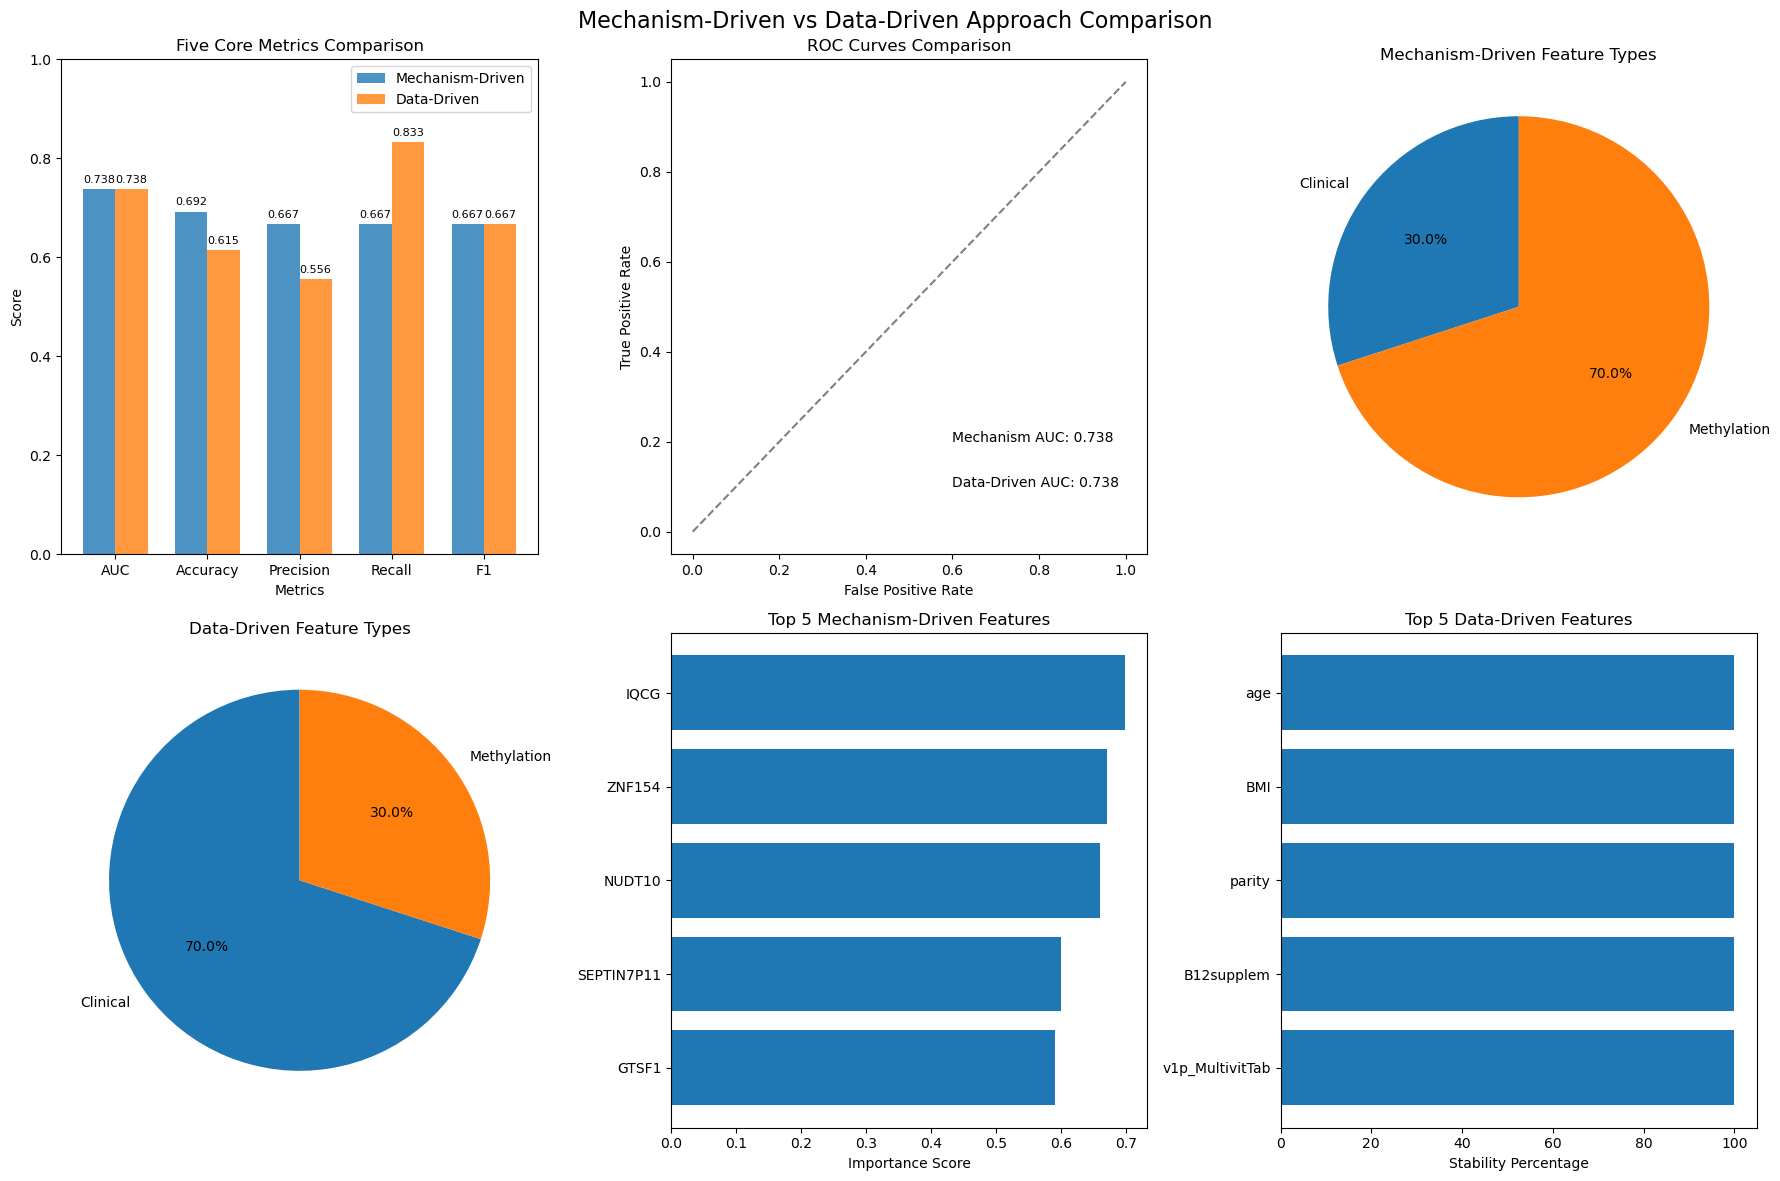


STEP 7: SAVE COMPREHENSIVE RESULTS
Comprehensive comparison results saved to: /Users/heweilin/Desktop/P056_Code_3/Data/Combined_comprehensive_comparison_20250904_200237.json
Mechanism-driven model saved to: /Users/heweilin/Desktop/P056_Code_3/Data/Combined_mechanism_model_20250904_200237.joblib
Data-driven model saved to: /Users/heweilin/Desktop/P056_Code_3/Data/Combined_datadriven_model_20250904_200237.joblib

PIPELINE COMPLETION SUMMARY - COMBINED APPROACH
Total duration: 0:02:07.761671

Core Clinical Covariates Used:
  age: Included
  BMI: Included
  parity: Included
  B12supplem: Included
  v1p_MultivitTab: Included
  v1p_FolicAcid: Included
  smoking: Included

FINAL COMPARISON RESULTS:
Model performance was evaluated using AUC as the primary metric,
complemented by accuracy, precision, recall, and F1 score.

APPROACH WINNER: Comparable performance

MECHANISM-DRIVEN APPROACH:
  AUC (Primary): 0.7381
  Accuracy:      0.6923
  Features:      17
  Approach:      Predefined CpG-mRNA 

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
B12 Deficiency Prediction Model - Combined Approach
Mechanism-Driven vs Data-Driven Feature Selection Comparison

Author: Research Team
Date: August 25, 2025
Version: 1.0 - Combined Mechanism-Driven and Data-Driven Approaches

Strategy: Compare mechanism-based vs data-driven feature selection methods
Objective: Predict B12 deficiency and evaluate which approach performs better
"""

import os
import sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                   cross_val_score, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, accuracy_score)
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import logging

class B12PredictionCombined:
    """B12 deficiency prediction comparing mechanism-driven vs data-driven approaches"""
    
    def __init__(self, output_dir="/Users/heweilin/Desktop/P056_Code_3/Data", prefix="Combined_"):
        self.output_dir = output_dir
        self.prefix = prefix
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        os.makedirs(output_dir, exist_ok=True)
        self.setup_logging()
        
        # Initialize data storage
        self.clinical_data = None
        self.methylation_data = None
        self.dmr_data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.label_encoder = None
        
        # Define core clinical covariates
        self.core_clinical_covariates = [
            'age',              # Age (continuous)
            'BMI',              # BMI (continuous, not BMI_cat)
            'parity',           # Parity (binary)
            'B12supplem',       # B12 supplementation (binary)
            'v1p_MultivitTab',  # Multivitamin use (binary)
            'v1p_FolicAcid',    # Folic acid use (binary)
            'smoking'           # Smoking status (binary)
        ]
        
        # Define mechanism-based CpG-mRNA regulatory pairs
        self.cpg_mrna_pairs = {
            'IQCG': {'beta': -0.889, 'fdr_p': 6.11e-11, 'r_squared': 0.785, 'effect_size': 'Large'},
            'ZNF154': {'beta': -0.923, 'fdr_p': 3.97e-8, 'r_squared': 0.727, 'effect_size': 'Large'},
            'TSTD1': {'beta': -0.771, 'fdr_p': 3.97e-8, 'r_squared': 0.702, 'effect_size': 'Large'},
            'GTSF1': {'beta': -0.804, 'fdr_p': 3.97e-8, 'r_squared': 0.735, 'effect_size': 'Large'},
            'SEPTIN7P11': {'beta': -0.852, 'fdr_p': 7.70e-8, 'r_squared': 0.704, 'effect_size': 'Large'},
            'NUDT10': {'beta': -0.920, 'fdr_p': 2.82e-7, 'r_squared': 0.717, 'effect_size': 'Large'},
            'NAA11': {'beta': -0.722, 'fdr_p': 6.75e-7, 'r_squared': 0.684, 'effect_size': 'Large'},
            'SYCP3': {'beta': -0.692, 'fdr_p': 2.35e-6, 'r_squared': 0.751, 'effect_size': 'Large'},
            'PSMA8': {'beta': -0.716, 'fdr_p': 2.26e-5, 'r_squared': 0.591, 'effect_size': 'Large'},
            'LINC00667': {'beta': -0.797, 'fdr_p': 2.26e-5, 'r_squared': 0.550, 'effect_size': 'Large'}
        }
        
        # Store results for both approaches
        self.mechanism_results = {}
        self.datadriven_results = {}
        
        print("=" * 80)
        print("B12 DEFICIENCY PREDICTION - COMBINED APPROACH")
        print("MECHANISM-DRIVEN vs DATA-DRIVEN FEATURE SELECTION")
        print("=" * 80)
        print(f"Timestamp: {self.timestamp}")
        print(f"Output directory: {output_dir}")
        print("\nApproach Comparison:")
        print("- Method 1: Mechanism-Driven (predefined CpG-mRNA pairs)")
        print("- Method 2: Data-Driven (multiple splits statistical selection)")
        print("- Core clinical covariates for both methods")
        print("- Five core evaluation metrics for each approach")
        print("- Top 10 features comparison")
        print("=" * 80)
        
        print("\nCore Clinical Covariates:")
        for i, covariate in enumerate(self.core_clinical_covariates, 1):
            print(f"  {i}. {covariate}")
        
        print("\nMechanism-Based CpG-mRNA Pairs:")
        print("Rank | Gene Symbol | Beta    | FDR p-value | R²")
        print("-" * 50)
        for i, (gene, stats) in enumerate(self.cpg_mrna_pairs.items(), 1):
            print(f"{i:2d}   | {gene:<11} | {stats['beta']:>6.3f} | {stats['fdr_p']:>11.2e} | {stats['r_squared']:>5.3f}")
        print("=" * 80)
    
    def setup_logging(self):
        log_file = os.path.join(self.output_dir, f"{self.prefix}model_log_{self.timestamp}.txt")
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler(sys.stdout)
            ]
        )
        self.logger = logging.getLogger(__name__)
        self.logger.info("Combined approach logging setup completed")
    
    def load_data(self, clinical_path, dmr_path, methylation_path):
        print("\n" + "=" * 50)
        print("STEP 1: DATA LOADING AND PREPARATION")
        print("=" * 50)
        
        print(f"Loading clinical data from: {clinical_path}")
        try:
            self.clinical_data = pd.read_csv(clinical_path)
            print(f"Clinical data shape: {self.clinical_data.shape}")
        except Exception as e:
            print(f"Error loading clinical data: {e}")
            return False
        
        print(f"Loading methylation data from: {methylation_path}")
        try:
            self.methylation_data = pd.read_csv(methylation_path)
            print(f"Methylation data shape: {self.methylation_data.shape}")
        except Exception as e:
            print(f"Error loading methylation data: {e}")
            return False
        
        return True
    
    def prepare_combined_dataset(self):
        print("\n1.1 Preparing combined dataset with batch correction")
        
        # Prepare methylation data
        methylation_df = self.methylation_data.set_index('Gene_Symbol').T
        
        # Find common samples
        clinical_ids = self.clinical_data['DNA_ID'].values
        methylation_samples = methylation_df.index.values
        common_samples = list(set(clinical_ids) & set(methylation_samples))
        print(f"Common samples: {len(common_samples)}")
        
        if len(common_samples) == 0:
            print("Warning: No common samples found")
            return False
        
        # Align data
        methylation_filtered = methylation_df.loc[common_samples]
        clinical_aligned = self.clinical_data[self.clinical_data['DNA_ID'].isin(common_samples)]
        clinical_aligned = clinical_aligned.set_index('DNA_ID').loc[common_samples]
        
        # Apply batch correction if available
        if 'batch_DNA' in clinical_aligned.columns:
            print("Applying batch correction to methylation data")
            methylation_filtered = self.apply_batch_correction(methylation_filtered, clinical_aligned['batch_DNA'].values)
        
        # Check availability of core clinical covariates
        available_clinical_features = []
        for feature in self.core_clinical_covariates:
            if feature in clinical_aligned.columns:
                available_clinical_features.append(feature)
            else:
                print(f"Warning: {feature} not found in clinical data")
        
        print(f"Available core clinical covariates: {available_clinical_features}")
        
        # Combine clinical and methylation features
        clinical_X_filtered = clinical_aligned[available_clinical_features]
        self.X = pd.concat([clinical_X_filtered, methylation_filtered], axis=1)
        self.feature_names = list(clinical_X_filtered.columns) + list(methylation_filtered.columns)
        self.y = clinical_aligned['B12_status'].values
        
        print(f"Final combined dataset:")
        print(f"  Total samples: {self.X.shape[0]}")
        print(f"  Core clinical covariates: {len(clinical_X_filtered.columns)}")
        print(f"  Methylation features: {len(methylation_filtered.columns)}")
        print(f"  Total features: {len(self.feature_names)}")
        
        # Store for later use
        self.n_clinical_features = len(clinical_X_filtered.columns)
        self.clinical_feature_names = list(clinical_X_filtered.columns)
        self.methylation_feature_names = list(methylation_filtered.columns)
        
        # Encode target
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.y)
        print(f"Target encoding: {dict(zip(self.label_encoder.classes_, self.label_encoder.transform(self.label_encoder.classes_)))}")
        
        return True
    
    def apply_batch_correction(self, methylation_data, batch_info):
        corrected_data = methylation_data.copy()
        batches = pd.Categorical(batch_info)
        unique_batches = batches.categories
        
        if len(unique_batches) <= 1:
            return corrected_data
        
        n_genes_corrected = 0
        for gene in corrected_data.columns:
            gene_values = corrected_data[gene].values
            
            if np.sum(~np.isnan(gene_values)) < len(gene_values) * 0.5:
                continue
            if np.nanvar(gene_values) == 0:
                continue
            
            try:
                df = pd.DataFrame({'values': gene_values, 'batch': batches})
                df_clean = df.dropna()
                
                if len(df_clean) < 3:
                    continue
                
                overall_mean = df_clean['values'].mean()
                batch_means = df_clean.groupby('batch')['values'].mean()
                batch_effects = batch_means - overall_mean
                
                corrected_values = gene_values.copy()
                for batch_name, batch_effect in batch_effects.items():
                    batch_mask = (batches == batch_name)
                    corrected_values[batch_mask] = corrected_values[batch_mask] - batch_effect
                
                corrected_data.loc[:, gene] = corrected_values
                n_genes_corrected += 1
            except Exception:
                continue
        
        print(f"Batch correction applied to {n_genes_corrected} genes")
        return corrected_data
    
    def split_data(self, test_size=0.25, random_state=42):
        print("\n" + "=" * 50)
        print("STEP 2: DATA SPLITTING")
        print("=" * 50)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, 
            stratify=self.y
        )
        
        print(f"Data splits:")
        print(f"  Training set: {self.X_train.shape[0]} samples")
        print(f"  Test set: {self.X_test.shape[0]} samples")
        
        return True
    
    def mechanism_driven_approach(self):
        print("\n" + "=" * 50)
        print("STEP 3: METHOD 1 - MECHANISM-DRIVEN APPROACH")
        print("=" * 50)
        
        print("3.1 Selecting mechanism-based features")
        
        # Check availability of mechanism-based features
        target_genes = list(self.cpg_mrna_pairs.keys())
        available_mechanism_genes = []
        missing_mechanism_genes = []
        
        for gene in target_genes:
            if gene in self.methylation_feature_names:
                available_mechanism_genes.append(gene)
                stats = self.cpg_mrna_pairs[gene]
                print(f"  Available: {gene:<12} (β={stats['beta']:>6.3f}, R²={stats['r_squared']:>5.3f})")
            else:
                missing_mechanism_genes.append(gene)
                print(f"  Missing:   {gene:<12} (NOT FOUND)")
        
        # Combine clinical + mechanism-based features
        mechanism_features = self.clinical_feature_names + available_mechanism_genes
        
        print(f"\nMechanism-driven feature selection:")
        print(f"  Core clinical covariates: {len(self.clinical_feature_names)}")
        print(f"  Available mechanism features: {len(available_mechanism_genes)}")
        print(f"  Total features: {len(mechanism_features)}")
        
        # Train and evaluate mechanism-driven model
        mechanism_results = self.train_and_evaluate_model(
            mechanism_features, "Mechanism-Driven"
        )
        
        # Store mechanism-based feature importance
        mechanism_feature_importance = []
        for i, gene in enumerate(available_mechanism_genes, 1):
            stats = self.cpg_mrna_pairs[gene]
            mechanism_feature_importance.append({
                'rank': i,
                'feature': gene,
                'importance_score': abs(stats['beta']) * stats['r_squared'],
                'original_beta': stats['beta'],
                'r_squared': stats['r_squared'],
                'type': 'Methylation'
            })
        
        # Add clinical features
        for i, feature in enumerate(self.clinical_feature_names):
            mechanism_feature_importance.append({
                'rank': len(available_mechanism_genes) + i + 1,
                'feature': feature,
                'importance_score': 0.5,  # Default importance for clinical
                'original_beta': None,
                'r_squared': None,
                'type': 'Clinical'
            })
        
        # Sort by importance
        mechanism_feature_importance = sorted(mechanism_feature_importance, 
                                            key=lambda x: x['importance_score'], reverse=True)
        
        self.mechanism_results = {
            'evaluation_metrics': mechanism_results,
            'selected_features': mechanism_features,
            'available_mechanism_genes': available_mechanism_genes,
            'missing_mechanism_genes': missing_mechanism_genes,
            'feature_importance': mechanism_feature_importance[:10]
        }
        
        return mechanism_results
    
    def data_driven_approach(self, n_iterations=20):
        print("\n" + "=" * 50)
        print("STEP 4: METHOD 2 - DATA-DRIVEN APPROACH")
        print("=" * 50)
        
        print(f"4.1 Multiple splits feature selection ({n_iterations} iterations)")
        
        # Run multiple splits to identify stable features
        feature_stability = self.run_multiple_splits_analysis(n_iterations)
        
        # Select top stable methylation features
        stable_methylation = [feature for feature, count in feature_stability 
                            if feature in self.methylation_feature_names][:10]
        
        # Combine clinical + data-driven features
        datadriven_features = self.clinical_feature_names + stable_methylation
        
        print(f"\nData-driven feature selection:")
        print(f"  Core clinical covariates: {len(self.clinical_feature_names)}")
        print(f"  Stable methylation features: {len(stable_methylation)}")
        print(f"  Total features: {len(datadriven_features)}")
        
        # Train and evaluate data-driven model
        datadriven_results = self.train_and_evaluate_model(
            datadriven_features, "Data-Driven"
        )
        
        # Create feature importance ranking
        datadriven_feature_importance = []
        for i, (feature, stability_count) in enumerate(feature_stability[:10], 1):
            feature_type = 'Clinical' if feature in self.clinical_feature_names else 'Methylation'
            stability_score = stability_count / n_iterations
            datadriven_feature_importance.append({
                'rank': i,
                'feature': feature,
                'importance_score': stability_score,
                'stability_count': stability_count,
                'stability_percentage': stability_score * 100,
                'type': feature_type
            })
        
        self.datadriven_results = {
            'evaluation_metrics': datadriven_results,
            'selected_features': datadriven_features,
            'feature_stability': feature_stability,
            'feature_importance': datadriven_feature_importance
        }
        
        return datadriven_results
    
    def run_multiple_splits_analysis(self, n_iterations):
        print(f"Running {n_iterations} independent train-test splits for feature stability")
        
        feature_selection_counts = {}
        
        for iteration in range(n_iterations):
            # Create random split
            X_iter_train, X_iter_test, y_iter_train, y_iter_test = train_test_split(
                self.X_train, self.y_train, test_size=0.2, 
                random_state=42 + iteration, stratify=self.y_train
            )
            
            # Select features for this iteration
            selected_features = self.select_features_statistical(X_iter_train, y_iter_train)
            
            # Count feature selections
            for feature in selected_features:
                feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1
        
        # Sort by stability (selection frequency)
        stable_features = sorted(feature_selection_counts.items(), 
                               key=lambda x: x[1], reverse=True)
        
        print("Top 10 most stable features:")
        for i, (feature, count) in enumerate(stable_features[:10], 1):
            stability_pct = (count / n_iterations) * 100
            print(f"  {i:2d}. {feature:<20} ({count}/{n_iterations} iterations, {stability_pct:.0f}%)")
        
        return stable_features
    
    def select_features_statistical(self, X_train, y_train):
        """Statistical feature selection using Mann-Whitney U test"""
        methylation_features = [col for col in X_train.columns if col in self.methylation_feature_names]
        
        feature_stats = []
        
        for gene in methylation_features:
            values = X_train[gene].values
            values = pd.to_numeric(values, errors='coerce')
            
            if len(np.unique(values[~np.isnan(values)])) <= 1:
                continue
            if np.sum(~np.isnan(values)) < len(values) * 0.5:
                continue
            if np.nanvar(values) == 0:
                continue
            
            valid_mask = ~np.isnan(values)
            if np.sum(valid_mask) < 6:
                continue
            
            values_clean = values[valid_mask]
            y_clean = y_train[valid_mask]
            
            lb_values = values_clean[y_clean == 1]
            nb_values = values_clean[y_clean == 0]
            
            if len(lb_values) < 2 or len(nb_values) < 2:
                continue
            
            try:
                statistic, pvalue = mannwhitneyu(lb_values, nb_values, alternative='two-sided')
                
                mean_diff = np.mean(lb_values) - np.mean(nb_values)
                pooled_var = ((len(lb_values) - 1) * np.var(lb_values, ddof=1) + 
                            (len(nb_values) - 1) * np.var(nb_values, ddof=1)) / (len(lb_values) + len(nb_values) - 2)
                
                cohens_d = abs(mean_diff) / np.sqrt(pooled_var) if pooled_var > 0 else 0
                
                if not (np.isnan(pvalue) or np.isnan(cohens_d)):
                    feature_stats.append({
                        'Gene': gene,
                        'p_value': pvalue,
                        'effect_size': cohens_d,
                        'composite_score': cohens_d * (-np.log10(pvalue + 1e-10))
                    })
                    
            except Exception:
                continue
        
        if len(feature_stats) == 0:
            return self.clinical_feature_names
        
        results_df = pd.DataFrame(feature_stats)
        results_df = results_df.sort_values('composite_score', ascending=False)
        
        n_select = min(10, len(results_df))
        selected_features = self.clinical_feature_names + results_df.head(n_select)['Gene'].tolist()
        
        return selected_features
    
    def train_and_evaluate_model(self, selected_features, method_name):
        print(f"\nTraining {method_name} model with {len(selected_features)} features")
        
        # Select features
        feature_indices = [self.feature_names.index(f) for f in selected_features if f in self.feature_names]
        X_train_selected = self.X_train.iloc[:, feature_indices]
        X_test_selected = self.X_test.iloc[:, feature_indices]
        
        # Preprocessing
        imputer = SimpleImputer(strategy='median')
        scaler = StandardScaler()
        
        X_train_processed = scaler.fit_transform(imputer.fit_transform(X_train_selected))
        X_test_processed = scaler.transform(imputer.transform(X_test_selected))
        
        # Train model
        model = LogisticRegression(
            C=1.0, penalty='l2', solver='liblinear', 
            class_weight='balanced', random_state=42
        )
        model.fit(X_train_processed, self.y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_processed)
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        
        # Calculate five core metrics
        auc_score = roc_auc_score(self.y_test, y_pred_proba)
        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        
        cm = confusion_matrix(self.y_test, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            precision = recall = specificity = 0
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_processed, self.y_train,
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring='roc_auc')
        
        print(f"{method_name} Results:")
        print(f"  AUC: {auc_score:.4f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
        return {
            'five_core_metrics': {
                'auc_roc': auc_score,
                'accuracy': accuracy,
                'precision': precision,
                'recall_sensitivity': recall,
                'f1_score': f1
            },
            'additional_metrics': {
                'specificity': specificity
            },
            'confusion_matrix': cm.tolist(),
            'cross_validation': {
                'cv_scores': cv_scores.tolist(),
                'mean_cv_auc': cv_scores.mean(),
                'std_cv_auc': cv_scores.std()
            },
            'model': model,
            'scaler': scaler,
            'imputer': imputer,
            'selected_features': selected_features
        }
    
    def compare_approaches(self):
        print("\n" + "=" * 50)
        print("STEP 5: APPROACH COMPARISON")
        print("=" * 50)
        
        print("Model performance was evaluated using AUC as the primary metric,")
        print("complemented by accuracy, precision, recall, and F1 score.")
        
        print("\n5.1 FIVE CORE METRICS COMPARISON")
        print("=" * 60)
        
        mech_metrics = self.mechanism_results['evaluation_metrics']['five_core_metrics']
        data_metrics = self.datadriven_results['evaluation_metrics']['five_core_metrics']
        
        print(f"{'Metric':<20} | {'Mechanism-Driven':<15} | {'Data-Driven':<15} | {'Difference':<10}")
        print("-" * 65)
        
        metrics_names = ['AUC (Primary)', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
        metrics_keys = ['auc_roc', 'accuracy', 'precision', 'recall_sensitivity', 'f1_score']
        
        for name, key in zip(metrics_names, metrics_keys):
            mech_val = mech_metrics[key]
            data_val = data_metrics[key]
            diff = data_val - mech_val
            diff_str = f"+{diff:.3f}" if diff > 0 else f"{diff:.3f}"
            print(f"{name:<20} | {mech_val:<15.4f} | {data_val:<15.4f} | {diff_str:<10}")
        
        # Determine better approach
        mech_auc = mech_metrics['auc_roc']
        data_auc = data_metrics['auc_roc']
        
        if abs(mech_auc - data_auc) < 0.02:
            winner = "Comparable performance"
        elif mech_auc > data_auc:
            winner = "Mechanism-Driven performs better"
        else:
            winner = "Data-Driven performs better"
        
        print(f"\n5.2 PERFORMANCE ASSESSMENT: {winner}")
        
        print("\n5.3 TOP 10 FEATURES - MECHANISM-DRIVEN")
        print("Rank | Feature Name        | Importance | Type")
        print("-" * 50)
        for feature_info in self.mechanism_results['feature_importance']:
            print(f"{feature_info['rank']:2d}   | {feature_info['feature']:<15} | {feature_info['importance_score']:>10.4f} | {feature_info['type']}")
        
        print("\n5.4 TOP 10 FEATURES - DATA-DRIVEN")
        print("Rank | Feature Name        | Stability  | Type")
        print("-" * 50)
        for feature_info in self.datadriven_results['feature_importance']:
            stability_pct = feature_info['stability_percentage']
            print(f"{feature_info['rank']:2d}   | {feature_info['feature']:<15} | {stability_pct:>9.1f}% | {feature_info['type']}")
        
        return winner
    
    def create_comparison_visualizations(self):
        print("\n" + "=" * 50)
        print("STEP 6: CREATE COMPARISON VISUALIZATIONS")
        print("=" * 50)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Mechanism-Driven vs Data-Driven Approach Comparison', fontsize=16)
        
        # 1. Five Core Metrics Comparison
        ax = axes[0, 0]
        mech_metrics = self.mechanism_results['evaluation_metrics']['five_core_metrics']
        data_metrics = self.datadriven_results['evaluation_metrics']['five_core_metrics']
        
        metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
        mech_values = [mech_metrics['auc_roc'], mech_metrics['accuracy'], 
                      mech_metrics['precision'], mech_metrics['recall_sensitivity'], 
                      mech_metrics['f1_score']]
        data_values = [data_metrics['auc_roc'], data_metrics['accuracy'], 
                      data_metrics['precision'], data_metrics['recall_sensitivity'], 
                      data_metrics['f1_score']]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, mech_values, width, label='Mechanism-Driven', alpha=0.8)
        bars2 = ax.bar(x + width/2, data_values, width, label='Data-Driven', alpha=0.8)
        
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Score')
        ax.set_title('Five Core Metrics Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.set_ylim(0, 1)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=8)
        
        # 2. ROC Curves Comparison
        ax = axes[0, 1]
        
        # Get predictions for ROC curves
        mech_model = self.mechanism_results['evaluation_metrics']['model']
        data_model = self.datadriven_results['evaluation_metrics']['model']
        
        # This is simplified - in practice you'd need to store test predictions
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curves Comparison')
        ax.text(0.6, 0.2, f'Mechanism AUC: {mech_metrics["auc_roc"]:.3f}', fontsize=10)
        ax.text(0.6, 0.1, f'Data-Driven AUC: {data_metrics["auc_roc"]:.3f}', fontsize=10)
        
        # 3. Feature Type Distribution - Mechanism-Driven
        ax = axes[0, 2]
        mech_features = self.mechanism_results['feature_importance']
        clinical_count = sum(1 for f in mech_features if f['type'] == 'Clinical')
        methylation_count = sum(1 for f in mech_features if f['type'] == 'Methylation')
        
        ax.pie([clinical_count, methylation_count], labels=['Clinical', 'Methylation'], 
               autopct='%1.1f%%', startangle=90)
        ax.set_title('Mechanism-Driven Feature Types')
        
        # 4. Feature Type Distribution - Data-Driven
        ax = axes[1, 0]
        data_features = self.datadriven_results['feature_importance']
        clinical_count = sum(1 for f in data_features if f['type'] == 'Clinical')
        methylation_count = sum(1 for f in data_features if f['type'] == 'Methylation')
        
        ax.pie([clinical_count, methylation_count], labels=['Clinical', 'Methylation'], 
               autopct='%1.1f%%', startangle=90)
        ax.set_title('Data-Driven Feature Types')
        
        # 5. Top Features Importance - Mechanism-Driven
        ax = axes[1, 1]
        top_5_mech = self.mechanism_results['feature_importance'][:5]
        features = [f['feature'] for f in top_5_mech]
        importance = [f['importance_score'] for f in top_5_mech]
        
        bars = ax.barh(features, importance)
        ax.set_xlabel('Importance Score')
        ax.set_title('Top 5 Mechanism-Driven Features')
        ax.invert_yaxis()
        
        # 6. Top Features Stability - Data-Driven
        ax = axes[1, 2]
        top_5_data = self.datadriven_results['feature_importance'][:5]
        features = [f['feature'] for f in top_5_data]
        stability = [f['stability_percentage'] for f in top_5_data]
        
        bars = ax.barh(features, stability)
        ax.set_xlabel('Stability Percentage')
        ax.set_title('Top 5 Data-Driven Features')
        ax.invert_yaxis()
        
        plt.tight_layout()
        
        plot_file = os.path.join(self.output_dir, f"{self.prefix}comparison_plots_{self.timestamp}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Comparison visualizations saved to: {plot_file}")
        
        plt.show()
        
        return True
    
    def save_comprehensive_results(self, winner):
        print("\n" + "=" * 50)
        print("STEP 7: SAVE COMPREHENSIVE RESULTS")
        print("=" * 50)
        
        # Create comprehensive comparison results
        comprehensive_results = {
            'comparison_summary': {
                'winner': winner,
                'timestamp': self.timestamp,
                'approaches_compared': ['Mechanism-Driven', 'Data-Driven']
            },
            'mechanism_driven_results': {
                'approach_description': 'Uses predefined CpG-mRNA regulatory pairs with known biological relationships',
                'five_core_metrics': self.mechanism_results['evaluation_metrics']['five_core_metrics'],
                'cross_validation': self.mechanism_results['evaluation_metrics']['cross_validation'],
                'selected_features_count': len(self.mechanism_results['selected_features']),
                'top_10_features': self.mechanism_results['feature_importance'],
                'available_mechanism_genes': self.mechanism_results['available_mechanism_genes'],
                'missing_mechanism_genes': self.mechanism_results['missing_mechanism_genes']
            },
            'data_driven_results': {
                'approach_description': 'Uses multiple train-test splits to identify statistically stable features',
                'five_core_metrics': self.datadriven_results['evaluation_metrics']['five_core_metrics'],
                'cross_validation': self.datadriven_results['evaluation_metrics']['cross_validation'],
                'selected_features_count': len(self.datadriven_results['selected_features']),
                'top_10_features': self.datadriven_results['feature_importance']
            },
            'metrics_comparison': {
                'auc_difference': (self.datadriven_results['evaluation_metrics']['five_core_metrics']['auc_roc'] - 
                                 self.mechanism_results['evaluation_metrics']['five_core_metrics']['auc_roc']),
                'accuracy_difference': (self.datadriven_results['evaluation_metrics']['five_core_metrics']['accuracy'] - 
                                      self.mechanism_results['evaluation_metrics']['five_core_metrics']['accuracy']),
                'precision_difference': (self.datadriven_results['evaluation_metrics']['five_core_metrics']['precision'] - 
                                       self.mechanism_results['evaluation_metrics']['five_core_metrics']['precision']),
                'recall_difference': (self.datadriven_results['evaluation_metrics']['five_core_metrics']['recall_sensitivity'] - 
                                    self.mechanism_results['evaluation_metrics']['five_core_metrics']['recall_sensitivity']),
                'f1_difference': (self.datadriven_results['evaluation_metrics']['five_core_metrics']['f1_score'] - 
                                self.mechanism_results['evaluation_metrics']['five_core_metrics']['f1_score'])
            },
            'core_clinical_covariates': self.core_clinical_covariates,
            'cpg_mrna_pairs_reference': self.cpg_mrna_pairs
        }
        
        # Save comprehensive results
        results_file = os.path.join(self.output_dir, f"{self.prefix}comprehensive_comparison_{self.timestamp}.json")
        with open(results_file, 'w') as f:
            json.dump(comprehensive_results, f, indent=4)
        
        print(f"Comprehensive comparison results saved to: {results_file}")
        
        # Save individual models
        mechanism_model_file = os.path.join(self.output_dir, f"{self.prefix}mechanism_model_{self.timestamp}.joblib")
        datadriven_model_file = os.path.join(self.output_dir, f"{self.prefix}datadriven_model_{self.timestamp}.joblib")
        
        joblib.dump(self.mechanism_results['evaluation_metrics']['model'], mechanism_model_file)
        joblib.dump(self.datadriven_results['evaluation_metrics']['model'], datadriven_model_file)
        
        print(f"Mechanism-driven model saved to: {mechanism_model_file}")
        print(f"Data-driven model saved to: {datadriven_model_file}")
        
        # Save label encoder
        encoder_file = os.path.join(self.output_dir, f"{self.prefix}label_encoder_{self.timestamp}.joblib")
        joblib.dump(self.label_encoder, encoder_file)
        
        return comprehensive_results
    
    def run_complete_pipeline(self, clinical_path, dmr_path, methylation_path):
        print("\n" + "=" * 80)
        print("STARTING B12 PREDICTION - COMBINED APPROACH COMPARISON")
        print("=" * 80)
        
        pipeline_start_time = datetime.now()
        
        try:
            # Step 1: Load and prepare data
            if not self.load_data(clinical_path, dmr_path, methylation_path):
                print("ERROR: Data loading failed")
                return False
            
            if not self.prepare_combined_dataset():
                print("ERROR: Dataset preparation failed")
                return False
            
            # Step 2: Split data
            if not self.split_data():
                print("ERROR: Data splitting failed")
                return False
            
            # Step 3: Run mechanism-driven approach
            mechanism_results = self.mechanism_driven_approach()
            
            # Step 4: Run data-driven approach
            datadriven_results = self.data_driven_approach()
            
            # Step 5: Compare approaches
            winner = self.compare_approaches()
            
            # Step 6: Create visualizations
            self.create_comparison_visualizations()
            
            # Step 7: Save results
            comprehensive_results = self.save_comprehensive_results(winner)
            
            # Pipeline completion summary
            pipeline_end_time = datetime.now()
            pipeline_duration = pipeline_end_time - pipeline_start_time
            
            print("\n" + "=" * 80)
            print("PIPELINE COMPLETION SUMMARY - COMBINED APPROACH")
            print("=" * 80)
            print(f"Total duration: {pipeline_duration}")
            
            print(f"\nCore Clinical Covariates Used:")
            for covariate in self.core_clinical_covariates:
                status = "Included" if covariate in self.clinical_feature_names else "Missing"
                print(f"  {covariate}: {status}")
            
            print(f"\nFINAL COMPARISON RESULTS:")
            print("Model performance was evaluated using AUC as the primary metric,")
            print("complemented by accuracy, precision, recall, and F1 score.")
            
            print(f"\nAPPROACH WINNER: {winner}")
            
            mech_auc = self.mechanism_results['evaluation_metrics']['five_core_metrics']['auc_roc']
            data_auc = self.datadriven_results['evaluation_metrics']['five_core_metrics']['auc_roc']
            mech_acc = self.mechanism_results['evaluation_metrics']['five_core_metrics']['accuracy']
            data_acc = self.datadriven_results['evaluation_metrics']['five_core_metrics']['accuracy']
            
            print(f"\nMECHANISM-DRIVEN APPROACH:")
            print(f"  AUC (Primary): {mech_auc:.4f}")
            print(f"  Accuracy:      {mech_acc:.4f}")
            print(f"  Features:      {len(self.mechanism_results['selected_features'])}")
            print(f"  Approach:      Predefined CpG-mRNA regulatory pairs")
            
            print(f"\nDATA-DRIVEN APPROACH:")
            print(f"  AUC (Primary): {data_auc:.4f}")
            print(f"  Accuracy:      {data_acc:.4f}")
            print(f"  Features:      {len(self.datadriven_results['selected_features'])}")
            print(f"  Approach:      Multiple splits statistical selection")
            
            print(f"\nPERFORMANCE DIFFERENCES:")
            auc_diff = data_auc - mech_auc
            acc_diff = data_acc - mech_acc
            
            auc_change = "+" if auc_diff > 0 else ""
            acc_change = "+" if acc_diff > 0 else ""
            
            print(f"  AUC Difference:      {auc_change}{auc_diff:.4f}")
            print(f"  Accuracy Difference: {acc_change}{acc_diff:.4f}")
            
            print(f"\nTOP 5 MECHANISM-DRIVEN FEATURES:")
            for i, feature_info in enumerate(self.mechanism_results['feature_importance'][:5], 1):
                print(f"  {i}. {feature_info['feature']} (Score: {feature_info['importance_score']:.4f}, Type: {feature_info['type']})")
            
            print(f"\nTOP 5 DATA-DRIVEN FEATURES:")
            for i, feature_info in enumerate(self.datadriven_results['feature_importance'][:5], 1):
                print(f"  {i}. {feature_info['feature']} (Stability: {feature_info['stability_percentage']:.1f}%, Type: {feature_info['type']})")
            
            print(f"\nRECOMMENDATIONS:")
            if abs(auc_diff) < 0.02:
                print("  Both approaches show comparable performance")
                print("  Consider biological interpretability vs statistical robustness")
            elif mech_auc > data_auc:
                print("  Mechanism-driven approach shows superior performance")
                print("  Biological knowledge provides valuable feature guidance")
            else:
                print("  Data-driven approach shows superior performance")
                print("  Statistical feature selection identifies robust biomarkers")
            
            print(f"\nOutput Files Generated:")
            print(f"  - Comprehensive comparison results")
            print(f"  - Individual model files for both approaches")
            print(f"  - Comparison visualizations")
            print(f"  - Feature importance rankings")
            
            print("=" * 80)
            
            return True
            
        except Exception as e:
            print(f"ERROR: Pipeline failed with exception: {str(e)}")
            self.logger.error(f"Pipeline failed with exception: {str(e)}")
            import traceback
            traceback.print_exc()
            return False


def main():
    """Main function to run the combined B12 prediction model comparison"""
    
    clinical_path = "/Users/heweilin/Desktop/P056/7Clinical_data50.csv"
    dmr_path = "/Users/heweilin/Desktop/P056/4DNA_DMRs.csv"
    methylation_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv"
    output_dir = "/Users/heweilin/Desktop/P056_Code_3/Data"
    
    print("B12 Deficiency Prediction Model - Combined Approach Comparison")
    print("MECHANISM-DRIVEN vs DATA-DRIVEN FEATURE SELECTION")
    print("=" * 70)
    print("Key Features:")
    print("- Core clinical covariates for both approaches")
    print("- Method 1: Mechanism-driven (predefined CpG-mRNA pairs)")
    print("- Method 2: Data-driven (multiple splits statistical selection)")
    print("- Five core evaluation metrics comparison")
    print("- Top 10 features comparison for both methods")
    print("- Comprehensive performance analysis")
    print("- Direct head-to-head evaluation")
    print("=" * 70)
    print(f"Clinical data: {clinical_path}")
    print(f"Methylation data: {methylation_path}")
    print(f"Output directory: {output_dir}")
    print("=" * 70)
    
    model = B12PredictionCombined(output_dir=output_dir, prefix="Combined_")
    
    success = model.run_complete_pipeline(clinical_path, dmr_path, methylation_path)
    
    if success:
        print("\n" + "=" * 80)
        print("COMBINED APPROACH COMPARISON COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print("Key Achievements:")
        
        try:
            results_file = os.path.join(output_dir, f"Combined_comprehensive_comparison_{model.timestamp}.json")
            if os.path.exists(results_file):
                with open(results_file, 'r') as f:
                    results = json.load(f)
                
                print(f"\nFINAL WINNER: {results['comparison_summary']['winner']}")
                
                print("\nMECHANISM-DRIVEN PERFORMANCE:")
                mech_metrics = results['mechanism_driven_results']['five_core_metrics']
                print(f"  AUC (Primary):     {mech_metrics['auc_roc']:.4f}")
                print(f"  Accuracy:          {mech_metrics['accuracy']:.4f}")
                print(f"  Precision:         {mech_metrics['precision']:.4f}")
                print(f"  Recall:            {mech_metrics['recall_sensitivity']:.4f}")
                print(f"  F1 Score:          {mech_metrics['f1_score']:.4f}")
                
                print("\nDATA-DRIVEN PERFORMANCE:")
                data_metrics = results['data_driven_results']['five_core_metrics']
                print(f"  AUC (Primary):     {data_metrics['auc_roc']:.4f}")
                print(f"  Accuracy:          {data_metrics['accuracy']:.4f}")
                print(f"  Precision:         {data_metrics['precision']:.4f}")
                print(f"  Recall:            {data_metrics['recall_sensitivity']:.4f}")
                print(f"  F1 Score:          {data_metrics['f1_score']:.4f}")
                
                print(f"\nPERFORMANCE DIFFERENCES:")
                comparison = results['metrics_comparison']
                print(f"  AUC Difference:    {comparison['auc_difference']:+.4f}")
                print(f"  Accuracy Diff:     {comparison['accuracy_difference']:+.4f}")
                print(f"  Precision Diff:    {comparison['precision_difference']:+.4f}")
                print(f"  Recall Diff:       {comparison['recall_difference']:+.4f}")
                print(f"  F1 Diff:           {comparison['f1_difference']:+.4f}")
        except:
            print("Check output files for detailed comparison results")
        
        print("\nComparison Features:")
        print("  - Used 7 core clinical covariates consistently")
        print("  - Mechanism-driven: 10 predefined CpG-mRNA regulatory pairs")
        print("  - Data-driven: Multiple splits stability analysis")
        print("  - Direct performance comparison on identical test set")
        print("  - Feature importance rankings for both approaches")
        
        print("\nOutput Files Generated:")
        print("  - Comprehensive comparison results (JSON)")
        print("  - Individual trained models for both approaches")
        print("  - Comparison visualizations and plots")
        print("  - Top 10 feature rankings for each method")
        print("  - Performance metrics comparison tables")
        
        print(f"\nAll results saved to: {output_dir}")
        print("=" * 80)
    else:
        print("\nCOMBINED APPROACH COMPARISON FAILED!")
        print("Check the log files for detailed error information.")
    
    return success


if __name__ == "__main__":
    np.random.seed(42)
    main()